Apologize for the messy notebook - still trying to mess around with this stuff.

## Prelim Prep/Imports

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [107]:
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")

In [110]:
# Using the Pandas bdate_range function, we calculate number of days taken to complete order (excluding weekends)
df['scheduled_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df['actual_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

# Drop null values
df = df.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])

# Drop dates before 2016
orders = df[df['Schedule Finish Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df = df[~df['Order'].isin(orders)]

df.head()

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
1154,102416,100001705,B267,138,13,114.0,PC,114.0,2016-12-20,2017-01-04,2017-02-23,2016-12-20,2016-12-20,2016-12-20,-48,12,0
1286,102122,100002109,B24490,138,1,150.0,ML,144.0,2016-12-22,2017-01-06,2017-01-03,2017-01-03,2017-01-03,2017-01-04,2,12,2
1296,102881,100001070,B25580,106,4,15.0,PC,15.0,2017-01-04,2017-01-10,2017-01-04,2017-01-04,2017-01-04,2017-01-05,2,5,2
1314,102640,100002351,B311,138,1,50.0,ML,50.0,2017-01-04,2017-01-10,2017-01-03,2017-01-03,2017-01-03,2017-01-05,3,5,3
1337,101980,100001957,B24365,138,1,450.0,ML,450.0,2017-01-09,2017-01-13,2017-01-05,2017-01-05,2017-01-05,2017-01-06,2,5,2


In [111]:
#Change the units to ML
df.loc[df["Unit"] == "µL", "Total order quantity"] = df["Total order quantity"]/1000
df.loc[df["Unit"] == "µL", "Unit"] = "ML"

df.loc[df["Unit"] == "L", "Total order quantity"] = df["Total order quantity"] * 1000
df.loc[df["Unit"] == "L", "Unit"] = "ML"

display(df.shape)
display(df.head())

(31903, 17)

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
1154,102416,100001705,B267,138,13,114.0,PC,114.0,2016-12-20,2017-01-04,2017-02-23,2016-12-20,2016-12-20,2016-12-20,-48,12,0
1286,102122,100002109,B24490,138,1,150.0,ML,144.0,2016-12-22,2017-01-06,2017-01-03,2017-01-03,2017-01-03,2017-01-04,2,12,2
1296,102881,100001070,B25580,106,4,15.0,PC,15.0,2017-01-04,2017-01-10,2017-01-04,2017-01-04,2017-01-04,2017-01-05,2,5,2
1314,102640,100002351,B311,138,1,50.0,ML,50.0,2017-01-04,2017-01-10,2017-01-03,2017-01-03,2017-01-03,2017-01-05,3,5,3
1337,101980,100001957,B24365,138,1,450.0,ML,450.0,2017-01-09,2017-01-13,2017-01-05,2017-01-05,2017-01-05,2017-01-06,2,5,2


## Grouping
Groups based on the assumption that the hierarchy is category -> group -> material from least precise to most precise. Starts by determining all possible groupings of material that have enough data to make a forecast, then moves to group, and finally to category. This information is stored in dictionaries mat_trend, group_trend, cat_trend.

In [112]:
# Could do all of the following in one nested for loop, but I've just done it separately for speed/ease
mat = df.groupby('Material')
mat_groups = dict(list(mat))

# material groupings that have enough data points for trend
mat_trend = {}

# material groupings that don't have enough data points for trend
mat_notrend = {}

# threshold value
mat_thresh = 75

for x in mat_groups:
    material = mat_groups[x]
    if len(material) > mat_thresh:
        mat_trend[x] = material
    else:
        mat_notrend[x] = material 

# Update df 
gr_trim_df = df[df.Material.isin(mat_notrend)]
        
print("Material groups that have enough data: %d" % len(mat_trend))
print("Material groups that do not have enough data: %d" % len(mat_notrend))
print(gr_trim_df.shape)

'Material groups that have enough data: 48'

'Material groups that do not have enough data: 2571'

(24580, 17)

In [113]:
# regroups
gr = df.groupby('Group')
group_groups = dict(list(gr))

# group groupings that have enough data points for trend
group_trend = {}

# group groupings that don't have enough data points for trend
group_notrend = {}

# threshhold
group_thresh = 75

for x in group_groups:
    group = group_groups[x]
    
    if len(group) > group_thresh:
        group_trend[x] = group
    else:
        group_notrend[x] = group 

# Update df 
cat_trim_df = df[df.Group.isin(group_notrend)]
        
print("Group groups that have enough data: %d" % len(group_trend))
print("Group groups that do not have enough data: %d" % len(group_notrend)) 
print(cat_trim_df.shape)

Group groups that have enough data: 41
Group groups that do not have enough data: 33


(947, 17)

In [114]:
# regroups
cat = df.groupby('MaterialCategory')
cat_groups = dict(list(cat))

# category groupings that have enough data points for trend
cat_trend = {}

# category groupings that don't have enough data points for trend
notrend = {}

# threshold
cat_thresh = 50

for x in cat_groups:
    category = cat_groups[x]
    if len(category) > cat_thresh:
        cat_trend[x] = category
    else:
        notrend[x] = category 
        
# Update df 
final_df = df[df.MaterialCategory.isin(notrend)]
        
print("Category groups that have enough data: %d" % len(cat_trend))
print("Category groups that do not have enough data: %d" % len(notrend))   
print(final_df.shape)

Category groups that have enough data: 11
Category groups that do not have enough data: 4


(18, 17)

In [115]:
print("Material groups that have enough data: %d" % len(mat_trend))
print("Material groups that do not have enough data: %d" % len(mat_notrend))
print("Group groups that have enough data: %d" % len(group_trend))
print("Group groups that do not have enough data: %d" % len(group_notrend)) 
print("Category groups that have enough data: %d" % len(cat_trend))
print("Category groups that do not have enough data: %d" % len(notrend)) 

Material groups that have enough data: 48
Material groups that do not have enough data: 2571
Group groups that have enough data: 41
Group groups that do not have enough data: 33
Category groups that have enough data: 11
Category groups that do not have enough data: 4


In [116]:
# List of all material categories that have enough data
mats = list(mat_trend.keys())

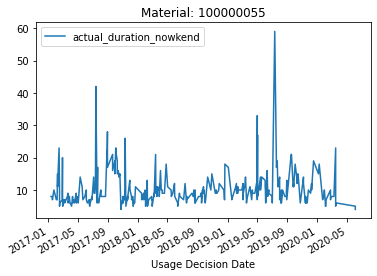

In [117]:
# Example of one of the material groupings that will be used in the notebook from now on to test an ARIMA model
# Foreseeably, this could be applied to all groupings
sub = df.loc[df['Material'] == mats[0]]
sub.plot(x = 'Usage Decision Date', y = 'actual_duration_nowkend', title = "Material: %d" % mats[0])

## Get Rid of Outliers

In [131]:
# Try to manually see outliers first
sub = sub.sort_values(by = ['actual_duration_nowkend'])
sub.describe()

,Order,Material,Group,MaterialCategory,Total order quantity,Quantity of goods received,dur,scheduled_duration_nowkend,actual_duration_nowkend
count,363.000000,363.0,363.0,363.0,363.000000,363.000000,363.000000,363.000000,363.000000
mean,115067.515152,100000055.0,137.0,13.0,1873.498623,1860.798898,10.303030,9.129477,10.303030
std,8357.508790,0.0,0.0,0.0,68.901338,65.184785,5.768716,3.046107,5.768716
min,100776.000000,100000055.0,137.0,13.0,700.000000,722.000000,4.000000,3.000000,4.000000
25%,108040.000000,100000055.0,137.0,13.0,1885.000000,1864.000000,7.000000,6.000000,7.000000
50%,112945.000000,100000055.0,137.0,13.0,1885.000000,1868.000000,9.000000,11.000000,9.000000
75%,122794.000000,100000055.0,137.0,13.0,1885.000000,1873.000000,11.000000,12.000000,11.000000
max,130726.000000,100000055.0,137.0,13.0,1885.000000,1888.000000,59.000000,20.000000,59.000000


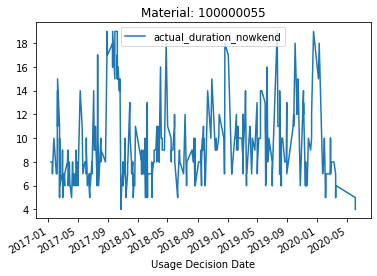

In [157]:
# Get rid of points three standard deviations away
sub['zscore'] = np.abs(stats.zscore(sub['actual_duration_nowkend']))
sub = sub.loc[sub['zscore'] < 3]
sub.plot(x = 'Usage Decision Date', y = 'actual_duration_nowkend', title = "Material: %d" % mats[0])
# Sort/order by date
sub = sub.sort_values(by='Usage Decision Date')

## ARIMA MODELING

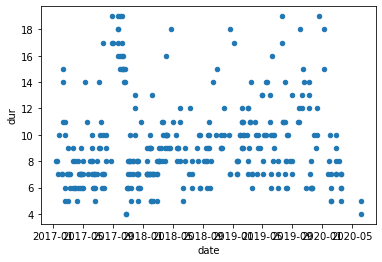

In [158]:
# Series of stamped time-series data
dates = sub['Usage Decision Date']
ts = pd.Series(sub['actual_duration_nowkend'].values, index=dates)

# Just visualizing data
dfmod = ts.to_frame()
dfmod.reset_index(inplace=True)
dfmod.columns = ['date','dur']
dfmod.plot(kind='scatter',x='date',y='dur')
plt.show()

In [159]:
# Array of external variables
exog_df = pd.DataFrame(sub['Total order quantity'])

# Convert to values for arima model
exog_arr = exog_df.values

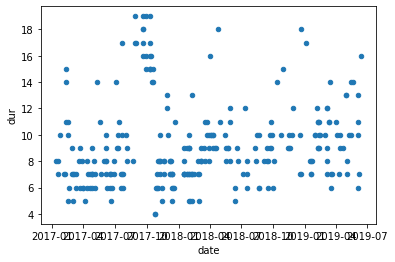

In [161]:
# Splitting data into test/train
ratio = 0.8
length = ts.shape[0]
pivot = int(ratio * length)
endpivot = length - pivot

ts_train = ts[:pivot]
ts_test = ts[pivot:]

exog_train = exog_arr[:pivot]
exog_test = exog_arr[pivot:]

dates_train = ts[:pivot]
dates_test = ts[pivot:]

# Just visualizing data
dfmod = ts_train.to_frame()
dfmod.reset_index(inplace=True)
dfmod.columns = ['date','dur']
dfmod.plot(kind = 'scatter', x='date',y='dur')
plt.show() 

In [162]:
# Fitting
arima = pm.auto_arima(ts_train, exog_train,start_p=1, start_q=1, max_p=3, max_q=3, m=12,start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings = True, stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=1279.824, BIC=1301.211, Time=2.651 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1492.345, BIC=1503.038, Time=0.167 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1367.622, BIC=1385.444, Time=0.927 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1279.621, BIC=1297.443, Time=1.660 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1490.350, BIC=1497.479, Time=0.247 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=1415.589, BIC=1433.411, Time=0.541 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=1281.737, BIC=1306.689, Time=3.381 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit ci

In [163]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  274
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -633.747
Date:                              Tue, 30 Jun 2020   AIC                           1279.494
Time:                                      19:45:19   BIC                           1300.881
Sample:                                           0   HQIC                          1288.091
                                              - 274                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.008      0.131      0.895      -0.014       0.016
x1            -0.0058      0.002     -3.618      0.000      -0.009      -0.003
ma.L1         -0.6046      0.053    -11.509      0.000      -0.708      -0.502
ma.L2         -0.0975      0.063     -1.543      0.123      -0.221       0.026
ma.S.L12      -0.9935      0.646     -1.538      0.124      -2.260       0.273
sigma2         6.5544      4.067      1.612      0.107      -1.417      14.525
===================================================================================
Ljung-Box (Q):                       38.86   Jarque-Bera (JB):                78.72
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.47
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
arima.fit(ts_train, exog_train)

ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

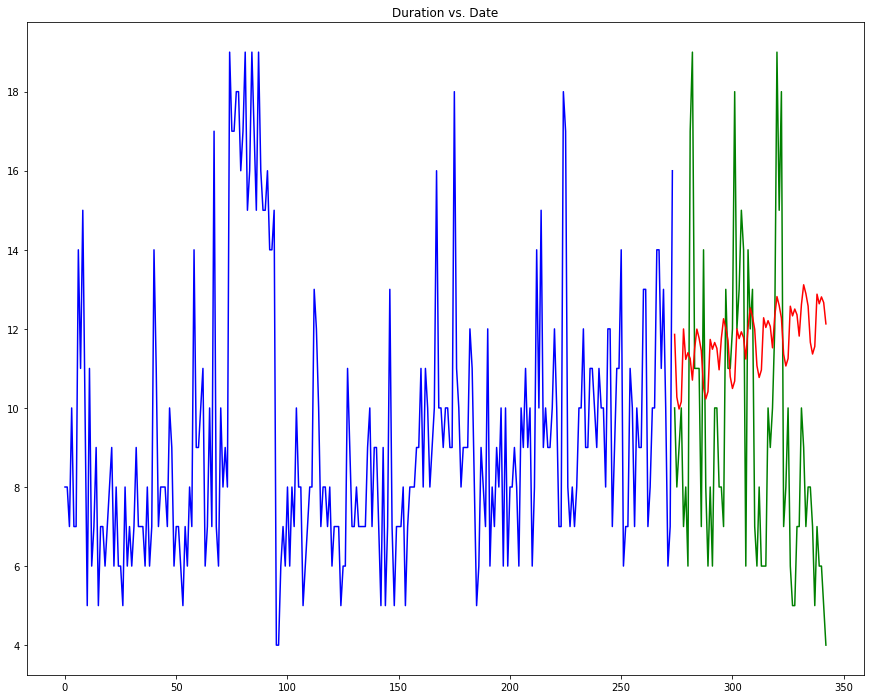

In [172]:
num_test = ts_test.shape[0]
# forecasts
forecasts = arima.predict(n_periods = num_test, exogenous = exog_test)  # predict 

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(length)
s = 2.0 ** 2
plt.plot(x[:pivot], ts_train, c='blue')
plt.plot(x[pivot:], ts_test, c = 'green')
plt.plot(x[pivot:], forecasts, c='red')
plt.gcf().set_size_inches(15, 12)
plt.title('Duration vs. Date')
plt.show()


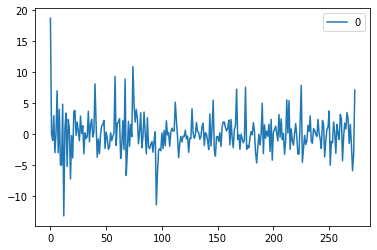

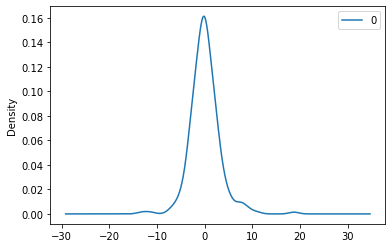

                0
count  274.000000
mean     0.062948
std      3.129008
min    -13.203033
25%     -1.731212
50%     -0.046279
75%      1.574754
max     18.720102


In [173]:
residuals = pd.DataFrame(arima.resid())
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [177]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(ts_test, forecasts)
print('Test MSE: %.3f' % error)

19.28713678680895
Test MSE: 19.287


## Second Try at ARIMA MODEL
Not completed

In [167]:
arima2 = pm.auto_arima(ts, exog_arr, m = 12, out_of_sample_size = endpivot, scoring = 'mse')

/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning

In [168]:
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  343
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -826.663
Date:                Tue, 30 Jun 2020   AIC                           1665.325
Time:                        19:49:09   BIC                           1688.352
Sample:                             0   HQIC                          1674.498
                                - 343                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9979      0.677      1.474      0.141      -0.329       2.325
x1            -0.0063      0.001     -4.215      0.000      -0.009      -0.003
ar.L1          0.9520      0.031     30.701      0.000       0.891       1.013
ma.L1         -0.5322      0.047    -11.236      0.000      -0.625      -0.439
ma.L2         -0.1261      0.052     -2.430      0.015      -0.228      -0.024
sigma2         6.7784      0.425     15.949      0.000       5.945       7.611
===================================================================================
Ljung-Box (Q):                       25.84   Jarque-Bera (JB):               102.67
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.71
Prob(H) (two-sided):                  0.42   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""